In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid")

os.makedirs("csv_files", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

In [24]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/fear_greed_index.csv')
trades_df = pd.read_csv('/content/drive/MyDrive/historical_data.csv')

In [25]:
print("Sentiment Data:")
display(sentiment_df.head())

print("Trader Data:")
display(trades_df.head())

Sentiment Data:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


Trader Data:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [26]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['timestamp'], unit='s')
sentiment_df.rename(columns={'classification': 'Market_Sentiment'}, inplace=True)

sentiment_df = sentiment_df[['date', 'Market_Sentiment']]
sentiment_df['date'] = sentiment_df['date'].dt.date

/tmp/ipython-input-26-766995967.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df['date'] = sentiment_df['date'].dt.date


In [27]:
trades_df['Timestamp IST'] = pd.to_datetime(trades_df['Timestamp IST'], format='%d-%m-%Y %H:%M')

trades_df['date'] = trades_df['Timestamp IST'].dt.date

required_cols = ['Account', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Closed PnL', 'date']

trades_df = trades_df[required_cols].copy()

trades_df.rename(columns={
    'Account': 'account',
    'Execution Price': 'execution_price',
    'Size Tokens': 'size_tokens',
    'Size USD': 'size_usd',
    'Side': 'side',
    'Closed PnL': 'closed_pnl'
}, inplace=True)

numeric_cols = ['execution_price', 'size_tokens', 'size_usd', 'closed_pnl']
trades_df[numeric_cols] = trades_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

trades_df.dropna(subset=['execution_price', 'size_tokens', 'size_usd', 'closed_pnl'], inplace=True)

In [28]:
merged_df = pd.merge(trades_df, sentiment_df, on='date', how='left')

print("Merged dataframe shape:", merged_df.shape)
display(merged_df[['account', 'execution_price', 'closed_pnl', 'Market_Sentiment']].head())

merged_df.to_csv("csv_files/processed_trader_data.csv", index=False)

Merged dataframe shape: (211224, 8)


,account,execution_price,closed_pnl,Market_Sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,7.9769,0.0,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,7.9800,0.0,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,7.9855,0.0,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,7.9874,0.0,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,7.9894,0.0,Extreme Greed


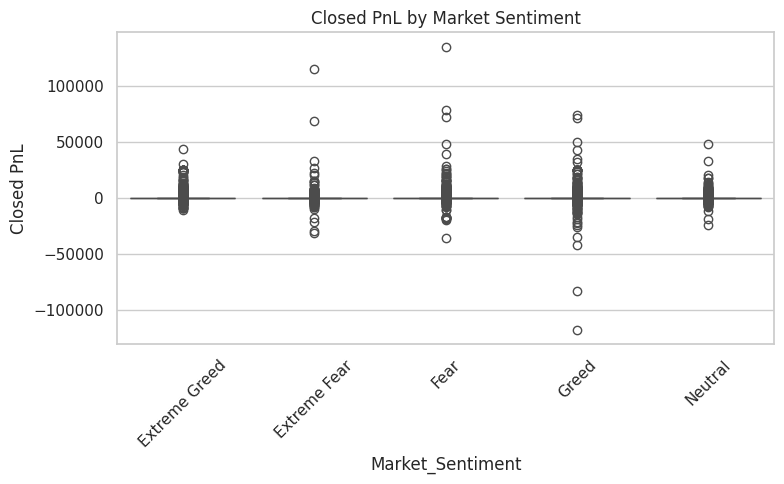

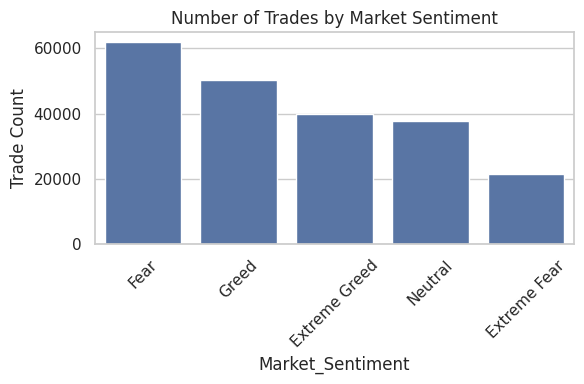

In [29]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Market_Sentiment', y='closed_pnl', data=merged_df)
plt.title("Closed PnL by Market Sentiment")
plt.ylabel("Closed PnL")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/pnl_vs_sentiment.png")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='Market_Sentiment', data=merged_df, order=merged_df['Market_Sentiment'].value_counts().index)
plt.title("Number of Trades by Market Sentiment")
plt.ylabel("Trade Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/tradecount_by_sentiment.png")
plt.show()

In [30]:
!ls csv_files

processed_trader_data.csv


In [31]:
!ls outputs/

pnl_vs_sentiment.png  tradecount_by_sentiment.png


In [32]:
from google.colab import files
files.download('csv_files/processed_trader_data.csv')
files.download('outputs/pnl_vs_sentiment.png')
files.download('outputs/tradecount_by_sentiment.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>